# Notebook Versions

- Version 1 (09/01/2024)
   * EDA and baseline modeling 1.0
   
   
- Version 2 (09/05/2024)
    * Baseline modeling 1.0 updated
    

- Version 3 (09/06/2024)
    * Baseline modeling 1.0 updated
    
    
- Version 4 (09/08/2024)
    * Baseline modeling 1.0 updated
   
# Loading Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

import xgboost as xgb
import lightgbm as lgb

from sklearn.neural_network import MLPRegressor
import optuna

CPU times: user 4 s, sys: 533 ms, total: 4.54 s
Wall time: 6.84 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e9/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e9/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (188533, 12)
The dimension of the test dataset is: (125690, 11)
CPU times: user 810 ms, sys: 118 ms, total: 928 ms
Wall time: 1.48 s


In [3]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
100*train.isnull().sum() / train.shape[0]

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [6]:
100*test.isnull().sum() / test.shape[0]

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.691543
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.298433
clean_title     11.328666
dtype: float64

From the above analysis, we can observe that both the `train` and `test` data frames contain approximately the same percentage of missing values. Next, we check for duplicates.

In [7]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the price column, there are {sum(train.drop(columns=['price']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the price column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [8]:
temp_train = train.drop(columns=['price'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by visualizing the distribution of `price`.

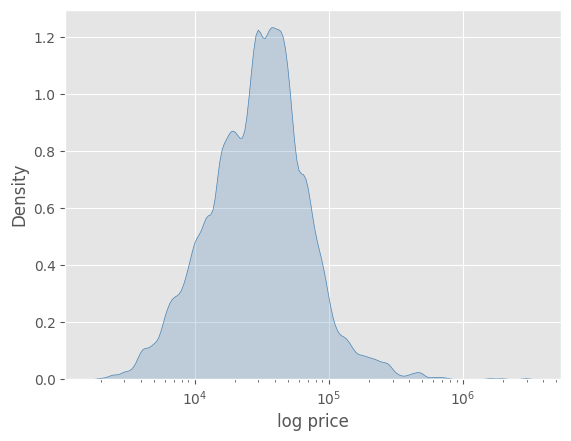

In [9]:
ax = sns.kdeplot(data=train, x='price', color='steelblue', fill=True, log_scale=True)
ax.set(xlabel='log price');

From the above chart, we see that the `log-price` distribution is more or less symmetric around 5x10^4 with tail on the right side of the distribution. 

<Axes: xlabel='milage', ylabel='price'>

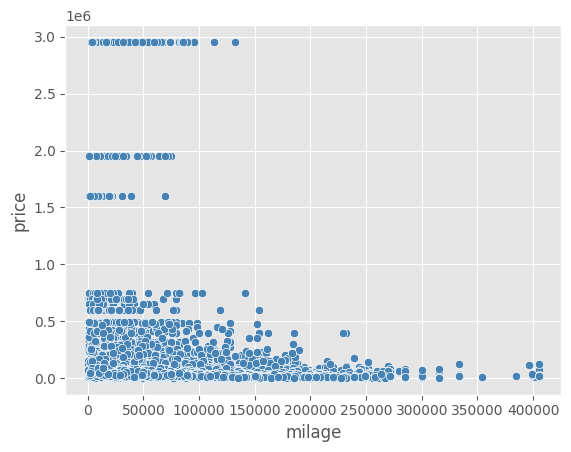

In [10]:
sns.scatterplot(data=train, x='milage', y='price', color='steelblue')

From the above chart, we can see that there is no a clear relationship between `mileage` and `price`. We next explore `model_year`.

In [11]:
train['model_year'].unique()

array([2007, 2002, 2017, 2021, 2018, 2016, 2020, 2015, 2011, 2013, 2023,
       2019, 2012, 2014, 2008, 2009, 2022, 2003, 2005, 2001, 2006, 2000,
       2010, 2004, 1997, 1998, 1999, 1994, 1993, 1996, 1995, 2024, 1974,
       1992])

In [12]:
test['model_year'].unique()

array([2015, 2020, 2022, 2016, 2018, 2013, 2008, 2019, 2017, 2002, 2023,
       2014, 2021, 2012, 2004, 2009, 2011, 2010, 2001, 2007, 2005, 2000,
       2003, 2006, 1999, 2024, 1997, 1993, 1994, 1998, 1995, 1996, 1992,
       1974, 1982, 1988])

Notice that the `train` and `test` data-frames don't have the same `model_year` values.

# Baseline Modeling 1.0

We build some standard models with the raw data. First, we preprocess the dat as follows:


In [13]:
%%time
def preprocessing(df, model, data):

    df = df.fillna('unknown')
    df = df.replace('–', 'dash')

    df['ext_col'] = np.where(df['ext_col']=='BLACK', 'Black', df['ext_col'])
    df['ext_col'] = np.where(np.isin(df['ext_col'], ['Blu', 'BLUE']), 'Blue', df['ext_col'])

    df['clean_title'] = df['clean_title'].map({'Yes': 1, 'unknown': 0}).astype('int8')
    df['accident'] = df['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1, 'unknown': 2}).astype('int8')

    if model == 'LGBM':
        
        df['brand'] = df['model'].str.split().str[0]
        df['age'] = 2024 - df['model_year']

        df = df.drop(columns=['model'], axis=1)

        cat_cols = ['brand', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
        for i in cat_cols:
            df[i] = df[i].astype('category')    

    else :

        cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
        for i in cat_cols:
            df[i] = df[i].astype('category')

    if data=='train':
        
        return df.drop(columns=['price'], axis=1), df['price']
    
    else :

        return df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


Next, we define the input and target variables.

In [14]:
%%time
X_lgb, Y = preprocessing(train, 'LGBM', 'train')
test_lgb = preprocessing(test, 'LGBM', 'test')

X_xgb, Y = preprocessing(train, 'XGB', 'train')
test_xgb = preprocessing(test, 'XGB', 'test')

skf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=10)

CPU times: user 3.12 s, sys: 63.3 ms, total: 3.18 s
Wall time: 3.18 s


Frist, we train the `LightGBM` model over a 10-fold cross validation strategy.

In [15]:
%%time
lgb_params = {'learning_rate': 0.052053786915819925,
              'n_estimators': 72,
              'max_depth': 9,
              'reg_alpha': 0.02774538402713039,
              'reg_lambda': 9.843688275376913,
              'num_leaves': 24,
              'colsample_bytree': 0.47932705216203014,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X_lgb, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X_lgb.iloc[train_index], X_lgb.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict(X_test)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = mean_squared_error(y_test, preds, squared=False)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict(test_lgb)
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof RMSE score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof RMSE score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 65413.25852365853
------------ Working on Fold 1 ------------
The oof RMSE score is 66220.43367208214
------------ Working on Fold 2 ------------
The oof RMSE score is 75509.00130457114
------------ Working on Fold 3 ------------
The oof RMSE score is 64887.170367149694
------------ Working on Fold 4 ------------
The oof RMSE score is 56649.03324435563
------------ Working on Fold 5 ------------
The oof RMSE score is 78169.60923369262
------------ Working on Fold 6 ------------
The oof RMSE score is 81444.63831939719
------------ Working on Fold 7 ------------
The oof RMSE score is 82801.52732217008
------------ Working on Fold 8 ------------
The oof RMSE score is 72787.9976183114
------------ Working on Fold 9 ------------
The oof RMSE score is 79589.64654086328
The 10-fold average oof RMSE score of the LGBM model is 72347.23161462517
The 10-fold std oof RMSE score of the LGBM model is 8223.760736921527
CPU times: user 

Next, we train the `XGBoost` model over a 10-fold cross validation strategy.

In [16]:
%%time
xgb_params ={'max_depth': 9,
             'learning_rate': 0.0762165385620691,
             'gamma': 2.659003093799351,
             'min_child_weight': 98,
             'colsample_bytree': 0.4716833964799532,
             'n_jobs': -1}

dtest = xgb.DMatrix(test_xgb, enable_categorical=True)

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X_xgb, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X_xgb.iloc[train_index], X_xgb.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
            
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
            
    xgb_md = xgb.train(xgb_params, dtrain, num_boost_round=50, evals=[(dvalid, 'validation')], verbose_eval=False)
    preds = xgb_md.predict(dvalid)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = mean_squared_error(y_test, preds, squared=False)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict(dtest)
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof RMSE score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof RMSE score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 65225.23679035443
------------ Working on Fold 1 ------------
The oof RMSE score is 66287.42611862866
------------ Working on Fold 2 ------------
The oof RMSE score is 75610.88870212848
------------ Working on Fold 3 ------------
The oof RMSE score is 64870.283197332756
------------ Working on Fold 4 ------------
The oof RMSE score is 56484.610838965804
------------ Working on Fold 5 ------------
The oof RMSE score is 77964.68424195463
------------ Working on Fold 6 ------------
The oof RMSE score is 81203.09436035724
------------ Working on Fold 7 ------------
The oof RMSE score is 82783.90685654568
------------ Working on Fold 8 ------------
The oof RMSE score is 72708.57926448305
------------ Working on Fold 9 ------------
The oof RMSE score is 79620.37664126564
The 10-fold average oof RMSE score of the XGBoost model is 72275.90870120164
The 10-fold std oof RMSE score of the XGBoost model is 8231.085081797868
CPU time

Next, we train the `CatBoost` model over the 10-fold cross validation strategy.

In [17]:
cb_params = {'learning_rate': 0.18252191086034636,
             'depth': 4,
             'bagging_temperature': 0.07795419593118418,
             'l2_leaf_reg': 7,
             'grow_policy': 'Lossguide',
             'task_type': 'GPU'}

cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']
test_pool = Pool(data=test_xgb, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X_xgb, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X_xgb.iloc[train_index], X_xgb.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostRegressor(loss_function='RMSE', iterations=300, **cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict(eval_pool)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = mean_squared_error(y_test, preds, squared=False)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict(test_pool)
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)    
print(f"The 10-fold average oof RMSE score of the CatBoost model is {cat_oof_score}")

------------ Working on Fold 0 ------------
The oof RMSE score is 65673.741479987
------------ Working on Fold 1 ------------
The oof RMSE score is 66287.4103454749
------------ Working on Fold 2 ------------
The oof RMSE score is 75527.72187105335
------------ Working on Fold 3 ------------
The oof RMSE score is 64968.02627127858
------------ Working on Fold 4 ------------
The oof RMSE score is 56463.43852379638
------------ Working on Fold 5 ------------
The oof RMSE score is 78229.05704331743
------------ Working on Fold 6 ------------
The oof RMSE score is 81577.05046022797
------------ Working on Fold 7 ------------
The oof RMSE score is 82676.47705602052
------------ Working on Fold 8 ------------
The oof RMSE score is 73114.68434721009
------------ Working on Fold 9 ------------
The oof RMSE score is 79683.69109606907
The 10-fold average oof RMSE score of the CatBoost model is 72420.12984944353


Finally, we run an `Optuna` experiment to blend the out-of-fold predictions of `LightGBM`, `XGBoost`, and `CatBoost`.

In [18]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']

def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(3)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['xgb_preds'].values + 
                    weights[2]*x_test['cat_preds'].values) 
        
        y_test = x_test['y']
        score = mean_squared_error(y_test, ens_pred, squared=False)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-09-08 14:52:55,257] A new study created in memory with name: no-name-120233b4-cca2-4a11-af89-f1b69649061d
[I 2024-09-08 14:52:55,378] Trial 3 finished with value: 91153.08969714928 and parameters: {'weight0': 0.6714819960193191, 'weight1': 0.9039254766427022, 'weight2': 0.489469369544769}. Best is trial 3 with value: 91153.08969714928.
[I 2024-09-08 14:52:55,390] Trial 0 finished with value: 84663.36679237301 and parameters: {'weight0': 0.38933591617900504, 'weight1': 0.9455636487750153, 'weight2': 0.5116374182880804}. Best is trial 0 with value: 84663.36679237301.
[I 2024-09-08 14:52:55,397] Trial 1 finished with value: 76066.03889123167 and parameters: {'weight0': 0.5680410349694255, 'weight1': 0.0789963109610631, 'weight2': 0.8100739467450881}. Best is trial 1 with value: 76066.03889123167.
[I 2024-09-08 14:52:55,406] Trial 2 finished with value: 80210.34969021972 and parameters: {'weight0': 0.6977027528870321, 'weight1': 0.3093499738732356, 'weight2': 0.6634739444138077}. B

CPU times: user 5min 10s, sys: 44.2 s, total: 5min 54s
Wall time: 4min 46s


In [19]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 72158.0083515631
  Params: 
    weight0: 0.31602324087965744
    weight1: 0.40904325384903983
    weight2: 0.286703280320025
CPU times: user 283 µs, sys: 32 µs, total: 315 µs
Wall time: 312 µs


Next, we consider the `LinearRegression` model as an approach to combine the out-of-fold predictions.

In [20]:
%%time
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    lm_md = LinearRegression().fit(x, y)
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    lm_pred = lm_md.predict(x_test)
    score = mean_squared_error(y_test, lm_pred, squared=False)
    scores.append(score)

LR_score = np.mean(scores)
print(f"The 10-fold oof average RMSE of the LR stacker is {LR_score}")

The 10-fold oof average RMSE of the LR stacker is 72157.41400656434
CPU times: user 1.26 s, sys: 1.05 s, total: 2.3 s
Wall time: 619 ms


Next, we combine the `Optuna` blend and the `LinearRegression` stacker as follows.

In [21]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    lm_md = LinearRegression().fit(x, y)
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    lm_pred = lm_md.predict(x_test)
    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['xgb_preds'] + w['weight2']*test['cat_preds'])
    final_pred = (lm_pred + optuna_pred) / 2
    score = mean_squared_error(y_test, final_pred, squared=False)
    scores.append(score)

Optuna_and_LR = np.mean(scores)
print(f"The 10-fold oof average RMSE of the LR stacker is {np.mean(Optuna_and_LR)}")

The 10-fold oof average RMSE of the LR stacker is 72155.26879257255
CPU times: user 1.31 s, sys: 1.04 s, total: 2.35 s
Wall time: 615 ms


The following table summarize the results of the intial experiments:

In [22]:
%%time
results = pd.DataFrame()
results['Model'] = ['LGBM', 'XGBoost', 'CatBoost', 'Optuna Blend', 'LR Stacker', 'Optuna + LR']
results['10-fold oof RMSE'] = [lgb_oof_score, xgb_oof_score, cat_oof_score, best_trial.value, LR_score, Optuna_and_LR]
results

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.83 ms


,Model,10-fold oof RMSE
0,LGBM,72347.231615
1,XGBoost,72275.908701
2,CatBoost,72420.129849
3,Optuna Blend,72158.008352
4,LR Stacker,72157.414007
5,Optuna + LR,72155.268793


From the above table, we see that `Optuna + LR` blend generates the best oof RMSE out of the six experiments. Thus, we use the `Optuna + LR` strategy blend the `LGBM`, `XGBoost`, and `CatBoost` predictions.

In [23]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds.head()

CPU times: user 25.7 ms, sys: 14.2 ms, total: 40 ms
Wall time: 39.4 ms


,lgb_preds,fold,xgb_preds,cat_preds
0,21360.896854,0,22770.595703,16864.640271
1,81733.398508,0,76022.328125,74160.281445
2,60323.841221,0,50065.156250,56169.073173
3,28120.974167,0,35504.464844,27061.686804
4,33572.725371,0,36321.031250,30221.667308


In [24]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    lm_md = LinearRegression().fit(x, y)   
    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    
    lm_pred = lm_md.predict(temp.drop(columns=['fold'], axis=1))
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['xgb_preds'] + w['weight2']*temp['cat_preds'])
    
    final_pred = (lm_pred + optuna_pred) / 2
    test_pred_final.append(final_pred)

CPU times: user 1.58 s, sys: 1.31 s, total: 2.9 s
Wall time: 765 ms


In [25]:
%%time
submission = pd.read_csv('../input/playground-series-s4e9/sample_submission.csv')
submission['price'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 38.1 ms, sys: 4.24 ms, total: 42.3 ms
Wall time: 72.3 ms


,id,price
0,188533,20910.421022
1,188534,79228.082175
2,188535,55728.384491
3,188536,31606.281602
4,188537,33501.551167


In [26]:
%time
submission.to_csv('baseline_sub_1.csv', index=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
